In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
from utils import *
from bs4 import BeautifulSoup
from collections import Counter

# Settlement value

## 1. Read files

read files and define the folder address

In [2]:
# load 1DTE option data
oneDTE_df = pd.read_csv(r"raw_data\OpitonMetrics\options_data\1DTE.csv")

# load the security price data
security_prices_df = pd.read_csv(r"raw_data\OpitonMetrics\securities_data\security_prices.csv")

# create the security close prices dict, date as the key and close price as the value
security_close_prices = {}
for index, row in security_prices_df.iterrows():
    security_close_prices[row['date']] = float(row['close'])
print(f'Security close prices dict has been created')

# create the US holidays list
# store the holidays as official csv file
raw_holidays = pd.read_csv(r"raw_data\US_holidays\raw_US_holidays.csv")
holidays = []
for key in raw_holidays.keys():
    for holiday in raw_holidays[key]:
        if pd.isna(holiday):
            continue
        holidays.append(holiday)

holidays.sort()
holidays_df = pd.DataFrame(holidays, columns=['date'])
holidays_df.to_csv(r"raw_data\US_holidays\US_holidays.csv")
print(f'Official US_holidays csv file has been created')

C:\Users\55479\AppData\Local\Temp\ipykernel_11956\3047742581.py:2: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  oneDTE_df = pd.read_csv(r"raw_data\OpitonMetrics\options_data\1DTE.csv")


Security close prices dict has been created
Official US_holidays csv file has been created


In [3]:
EOM_json_folder = os.getcwd() + r"\raw_data\CboeSettlementValues\EOM\json"
regular_json_folder = os.getcwd() + r"\raw_data\CboeSettlementValues\regular\json"
weekly_json_folder = os.getcwd() + r"\raw_data\CboeSettlementValues\weekly\json"
quarterly_json_folder = os.getcwd() + r"\raw_data\CboeSettlementValues\quarterly\json"

convert html to json files

In [4]:
convert_all_htmls_to_jsons()
print(f'All htmls of settlement values have been converted to json files')

All htmls of settlement values have been converted to json files


## 2. OSI analysis and processing

Option types in 1DTE data

In [5]:
# types before OSI of data
symbols = []
for i in oneDTE_df['symbol']:
    if '.' not in i.split(' ')[0] and 'SPX' in i.split(' ')[0]:
        symbols.append(i.split(' ')[0])
set(symbols)

# after a period, there are only SPX, SPXPM, SPXQ and SPXW

{'SPX', 'SPXPM', 'SPXQ', 'SPXW'}

Settlement value types in json file

In [6]:
# EOM settlement values description
pair_list = []
for root, dirs, files in os.walk(EOM_json_folder):
    for file in files:
        with open(EOM_json_folder + '\\' + file, 'r') as f:
            sv = json.load(f)['data']
        year_list = [(i['description'], i['settlement_symbol']) for i in sv if 'S&P 500' in i['description']]
        pair_list += year_list

set(pair_list)

{('S&P 500 CLOSE', 'SPX')}

In [7]:
# quaterly settlement values description
pair_list = []
for root, dirs, files in os.walk(quarterly_json_folder):
    for file in files:
        with open(quarterly_json_folder + '\\' + file, 'r') as f:
            sv = json.load(f)['data']
        year_list = [(i['description'], i['settlement_symbol']) for i in sv if 'S&P 500' in i['description']]
        pair_list += year_list

set(pair_list)

{('S&P 500', 'SPX'), ('S&P 500 MINI', 'XSP')}

In [8]:
# weekly settlement values description
pair_list = []
for root, dirs, files in os.walk(weekly_json_folder):
    for file in files:
        with open(weekly_json_folder + '\\' + file, 'r') as f:
            sv = json.load(f)['data']
        year_list = [(i['description'], i['settlement_symbol']) for i in sv if 'S&P 500' in i['description']]
        pair_list += year_list

set(pair_list)

{('Cboe NANOS S&P 500 Index Options Close', 'NANOS'),
 ('S&P 500', 'SET'),
 ('S&P 500', 'SPX'),
 ('S&P 500 CLOSE', 'SPX')}

In [9]:
# regular settlement values description
pair_list = []
for root, dirs, files in os.walk(regular_json_folder):
    for file in files:
        with open(regular_json_folder + '\\' + file, 'r') as f:
            sv = json.load(f)['data']
        year_list = [(i['description'], i['settlement_symbol']) for i in sv if 'S&P 500' in i['description']]
        pair_list += year_list

set(pair_list)

{('S&P 500', 'SET'),
 ('S&P 500 (SET)', 'SET'),
 ('S&P 500 PM Settled Options', 'SPX'),
 ('S&P 500 PM Settled Options', 'SPXPM'),
 ('S&P 500 PM-Settled', 'SPX'),
 ('S&P 500 Scored & Screened Index', 'ESGST')}

In [10]:
# for EOM and quarterly, they have dupliates and all the same (have been checked manually)

Get all SP500 option settlement values

In [11]:
generate_all_settlement_values_json()
print(f'The json file containing all settlement values has been created')

The json file containing all settlement values has been created


Analysis of SPXQ, SPXPM, SPXW, SPX in data

In [12]:
# check if all existing dates in regular settlement values are all close 3rd Friday
for date in list(set(create_regular_dates())):
    if not is_third_friday(date):
        print(date)

# 2022-04-14 is OK since Friday is good Friday
# the dates in regular settlement values are all close 3rd Friday
# partially prove that regular only for the 3rd Friday or close expiration

2022-04-14


SPXQ

In [13]:
# check the starting and ending dates for SPXQ
SPXQ_df = oneDTE_df[oneDTE_df['symbol'].str.split(" ").str[0] == "SPXQ"]
dates = list(set(SPXQ_df['exdate']))
dates.sort()
print(f'The starting and ending time of SPXQ are {dates[0], dates[-1]}')
print('\n')
print(dates)
print('\n')

# check if SPXQ is all represented by m for expiry indicator
print(set(SPXQ_df['expiry_indicator']))

# all represented by m

# {'2013-06-28', 
#  '2011-12-30', 
#  '2012-09-28', 
#  '2011-06-30', 
#  '2013-03-28', 
#  '2011-09-30', 
#  '2013-12-31', 
#  '2012-03-30', 
#  '2012-06-29'}

# all after 2010-12-10, close to end of month, cannot be SET, cannot be SPXPM (cannot find in regular), can only be SPX
# search in weekly, EOM and quarterly, all with SPX
# need to assume that regular does not provide any dates that cover close to end of month (partially prove)
# need to assume the PM settlement of SPXQ, so we can extract not found price in security close price

The starting and ending time of SPXQ are ('2011-06-30', '2013-12-31')


['2011-06-30', '2011-09-30', '2011-12-30', '2012-03-30', '2012-06-29', '2012-09-28', '2013-03-28', '2013-06-28', '2013-12-31']


{'m'}


SPXPM

In [14]:
# check the starting and ending dates for SPXPM
SPXPM_df = oneDTE_df[oneDTE_df['symbol'].str.split(" ").str[0] == "SPXPM"]
dates = list(set(SPXPM_df['exdate']))
dates.sort()
print(f'The starting and ending time of SPXPM are {dates[0], dates[-1]}')
print('\n')
print(dates)
print('\n')
# check if SPXPM is all represented by m for expiry indicator
print(set(SPXPM_df['expiry_indicator']))

# all represented by m

# {'2010-12-31', 
#  '2010-09-30', even maybe not SPX but SET
#  '2011-03-31', 
#  '2010-06-30'} even maybe not SPX but SET

# tricky, need to consider if all are weeklies, so skip at this moment

The starting and ending time of SPXPM are ('2010-06-30', '2011-03-31')


['2010-06-30', '2010-09-30', '2010-12-31', '2011-03-31']


{'m'}


SPXW

In [15]:
weekly_dates = create_weekly_dates()
EOM_dates = create_EOM_dates()
quarterly_dates = create_quarterly_dates()

# check some info on the SPXW
SPXW_df = oneDTE_df[oneDTE_df['symbol'].str.split(" ").str[0] == "SPXW"]
dates = list(set(SPXW_df['exdate']))
dates.sort()
print(dates[0], dates[-1])
print('\n')

# check if SPXW is all represented by w for expiry indicator
# for SPXW, all 3 types 
print(set(SPXW_df['expiry_indicator']))
print('\n')

# check if for all SPXW symbol from 2010-12-10, the settlement symbol is SPX for weekly json
# yes they are, all the settlement symbols are SPX after 2010-12-10
input_file= os.getcwd() + r"\all_settlement_values.json"
with open(input_file, 'r') as f:
    settlement_values = json.load(f)
for year, data in settlement_values['weekly'].items():
    for i in data:
        if (
            i['expiration_date'] != 'ONE' and
            i['expiration_date'] != 'TWO' and
            i['expiration_date'] != 'FOUR' and
            i['expiration_date'] != 'FIVE'
        ):
            assert not (
                i['expiration_date'] >= '2010-12-10' and
                i['settlement_symbol'] != 'SPX'
            )

SPXW_m_df = SPXW_df[SPXW_df['expiry_indicator'] == 'm']
SPXW_w_df = SPXW_df[SPXW_df['expiry_indicator'] == 'w']
SPXW_r_df = SPXW_df[pd.isna(SPXW_df['expiry_indicator'])]

# ---------------------------------------------------------------------------------------------

# check the m for SPXW
for i in list(set(SPXW_m_df['exdate'])):
    date = pd.to_datetime(i)
    if not (date.is_month_end or (date + pd.Timedelta(days=1)).is_month_end or (date + pd.Timedelta(days=2)).is_month_end):
        print(i)
print('2021-05-28 is completely right since it is recorded in end of month, so it can be a weekly as well as an end of month option')

# check if SPXW_m can be all found in weekly
for date in list(set(SPXW_m_df['exdate'])):
    assert date in weekly_dates + EOM_dates + quarterly_dates
print('SPXW_m can all be found in weekly, EOM and quarterly')

# check the starting and ending time of SPXW_m
# for the time there is not SET
SPXW_m_dates = list(set(SPXW_m_df['exdate']))
SPXW_m_dates.sort()
print(f'The starting and ending time of SPXW_w are {SPXW_m_dates[0], SPXW_m_dates[-1]}')
print('for this starting time there is not SET for SPXW_m')
print('\n')

#-----------------------------------------------------------------------------------------------

# check the w for SPXW, if all SPXW_w dates can be found in weekly
# check if the dates not in weekly are 3rd Friday
dates = list(set(SPXW_w_df['exdate']))
dates.sort()
print(f'The starting time and ending time of SPXW_w are {dates[0], dates[-1]}')
for date in list(set(SPXW_w_df['exdate'])):
    if (date not in weekly_dates):
        print(date)
print('\n')

#------------------------------------------------------------------------------------------------

# check SPXW_r
# not all are regular close 3rd Friday to expire, but most of them are covered by weekly
dates = list(set(SPXW_r_df['exdate']))
dates.sort()
print(f'The starting time and ending time of SPXW_r are {dates[0], dates[-1]}')
for date in dates:
    if date not in weekly_dates and not is_third_friday(date):
        print(date)

# SPXW_m, search in weekly, EOM and quarterly
# SPXW_r, search in regular and weekly, assume to be PM
# SPWX_W, 


2010-12-10 2023-09-01


{'m', nan, 'w'}


2021-05-28
2021-05-28 is completely right since it is recorded in end of month, so it can be a weekly as well as an end of month option
SPXW_m can all be found in weekly, EOM and quarterly
The starting and ending time of SPXW_w are ('2011-04-29', '2023-08-31')
for this starting time there is not SET for SPXW_m


The starting time and ending time of SPXW_w are ('2010-12-10', '2023-09-01')
2022-10-21
2018-12-05
2017-10-25


The starting time and ending time of SPXW_r are ('2017-05-19', '2023-08-29')
2019-04-18
2022-04-14


SPX

In [16]:
weekly_dates = create_weekly_dates()

# check some info on the SPX
SPX_df = oneDTE_df[oneDTE_df['symbol'].str.split(" ").str[0] == "SPX"]
dates = list(set(SPX_df['exdate']))
dates.sort()
print(f'The starting and ending time of SPX are {dates[0], dates[-1]}')
print('\n')

# for SPX, it has 3 types of expiry indicators
print(set(SPX_df['expiry_indicator']))
print('\n')

# create 3 sub datasets for w, m and r
SPX_w_df = SPX_df[SPX_df['expiry_indicator'] == 'w']
SPX_m_df = SPX_df[SPX_df['expiry_indicator'] == 'm']
SPX_r_df = SPX_df[pd.isna(SPX_df['expiry_indicator'])]

#--------------------------------------------------------------------------------

# check if SPX_w_df are all Friday but not 3rd Friday
# check if SPX_w_df dates can be found in weekly settelment values
for date in list(set(SPX_w_df['exdate'])):
    assert (not is_third_friday(date)) and is_friday(date) and date in weekly_dates
print("SPX_w are all weeklies, since all Friday but not the 3rd Friday")
print("SPX_w dates can all be found in weekly")
print('\n')

#---------------------------------------------------------------------------------

# check SPX with m, all options should be weekly options in weekly settlement values
for date in list(set(SPX_m_df['exdate'])):
    assert date in weekly_dates
print(set(SPX_m_df['exdate']))
print('SPX_m are all weeklies and can be found in weekly')
print('\n')

#---------------------------------------------------------------------------------

# check SPX_r_df dates are all 3rd Friday or 1 or 2 days around
# meaning that for SPX with r, directly use regular settlement values and AM settlement SET
for date in list(set(SPX_r_df['exdate'])):
    if not is_third_friday(date):
        print(date)

# SPX_w, weekly (all weekly features and covered in weekly)
# SPX_m, weekly (1. close to end of month, cannot found in regular 2. dates not in EOM or quarterly 3. dates covered in weekly)
# SPX_r, regular (use year month) (assume SPX_r give the right type, so AM SET) (if PM, then should be represented by SPXW, can be checked)

The starting and ending time of SPX are ('2010-05-28', '2023-08-18')


{'m', nan, 'w'}


SPX_w are all weeklies, since all Friday but not the 3rd Friday
SPX_w dates can all be found in weekly


{'2010-10-29', '2010-07-30', '2010-05-28'}
SPX_m are all weeklies and can be found in weekly


2019-04-18
2022-04-14


In [17]:
# for weekly, the complete date starts since 2010 - Oct - 01
# for weekly, EOM and quarterly have the same settlement symbol since 2010 - Dec - 10, which is SPX (proved in SPXW)
# for weekly, the index change from JXD to SPX since 2010 forth week of May (2010-05-28)

Compare SPX settlement value with security prices

In [18]:
# compare the settlement values for SPX with security price
# they are all the same, meaning that for all SPX and SPXPM settlement values, we can extract from the security close prices
input_file= os.getcwd()+ r"\all_settlement_values.json"
with open(input_file, 'r') as f:
    settlement_values = json.load(f)
for type in settlement_values.keys():
    for year, series in settlement_values[type].items():
        for i in series:
            if i['settlement_symbol'] == 'SPX' or i['settlement_symbol'] == 'SPXPM':
                try:
                    settlement_value = float(i['settlement_value'])
                    close_price = float(security_prices_df[security_prices_df['date'] == i['expiration_date']]['close'].values[0])
                except:
                    continue
                assert np.isclose(settlement_value, close_price, rtol=1e-5, atol=1e-5)

print(f'All SPX or SPXPM settlement values are exactly the same as security close prices')

All SPX or SPXPM settlement values are exactly the same as security close prices


Not all EOM and quarterly can be found in weekly

In [19]:
weekly_dates = create_weekly_dates()
EOM_dates = create_EOM_dates()
quarterly_dates = create_quarterly_dates()

print(set(EOM_dates).issubset(weekly_dates), set(quarterly_dates).issubset(weekly_dates))
print(f'Not all EOM or quarterly settlement values can be also found in weekly settlement values')

False False
Not all EOM or quarterly settlement values can be also found in weekly settlement values


Define OSI unfilled and see the percentage

In [20]:
# create the dataset with new OSI
OSI_df = oneDTE_df[oneDTE_df['exdate'] >= '2010-05-28']
OSI_security_price_df = security_prices_df[security_prices_df['date'] >= '2010-05-28']

# get the proportion of OSI new data set
print(f'The new OSI accounts for {len(OSI_df)/len(oneDTE_df):.5f} in the 1DTE data')
print(f'The new OSI accounts for {len(OSI_security_price_df)/len(security_prices_df):.5f} in the calendar')

# no root of new data set for contract symbol
print(f"There is no root for OSI: {all(pd.isna(i) for i in OSI_df['root'])}")

The new OSI accounts for 0.99027 in the 1DTE data
The new OSI accounts for 0.47925 in the calendar
There is no root for OSI: True


Fill in OSI

In [21]:
OSI_df = generate_filled_OSI_df(OSI_df, security_close_prices)
print(f'OSI dataset has been filled in with settlement values')

100%|██████████| 478104/478104 [01:02<00:00, 7663.35it/s]


OSI dataset has been filled in with settlement values


Dates cannot be filled for OSI

In [22]:
filled_df = OSI_df
missing_filled_df = filled_df[filled_df['settlement_value'] == 0]

missing_tuple = []
for index, row in missing_filled_df.iterrows():
    missing_tuple.append((row['exdate'], row['expiry_indicator'], row['starting_code']))
missing_tuple.sort()
print(set(missing_tuple))
print(f'Those exdates cannot be filled in with settlement values: settlement values not found')

# three dates are not filled in for OSI datasets

# {('2010-06-30', 'm', 'SPXPM'), SET, cannot find
#  ('2010-09-30', 'm', 'SPXPM'), SET, cannot find
#  ('2018-12-05', 'w', 'SPXW')}, SPX, error from CBOE, shall be removed since the option price is truly of 12-04 but 12-05 is not expiration day

{('2010-06-30', 'm', 'SPXPM'), ('2018-12-05', 'w', 'SPXW'), ('2010-09-30', 'm', 'SPXPM')}
Those exdates cannot be filled in with settlement values: settlement values not found


## 3. Old options analysis and processing

In [23]:
old_df = oneDTE_df[oneDTE_df['exdate'] < '2010-05-28']

Old options properties: all Friday, Saturday and quarterly

In [24]:
# check Friday and end of month or end of quarter of all the options
thursday_dates = []
old_dates = old_df['exdate']
for date in old_dates:
    assert (is_friday(date) or is_friday(date, -1) or is_friday(date, 1) or is_quarter_end(date))

    if not (is_friday(date) or is_friday(date, -1) or is_quarter_end(date)):
        thursday_dates.append(date)

all((date + pd.Timedelta(days=1)).strftime('%Y-%m-%d') in holidays for date in pd.to_datetime(thursday_dates))

# all old options are Thursday, Friday, Saturday and quarterly settlement
# for all Thursday, the next day is holiday

True

Fill in the old options

In [25]:
old_df = generate_filled_old_df(old_df)

100%|██████████| 4700/4700 [00:09<00:00, 477.76it/s]


Dates cannot be filled for old

In [26]:
filled_df = old_df
missing_filled_df = filled_df[filled_df['settlement_value'] == 0]

missing_tuple = []
for index, row in missing_filled_df.iterrows():
    missing_tuple.append(row['exdate'])
missing_tuple.sort()
print(set(missing_tuple))

for date in list(set(missing_tuple)):
    if not is_quarter_end(date):
        print(date)

# in old, all missing dates that cannot be filled in, in which 2006-06-29 and 2007-09-28 are weekly missing, the others are end of quarter missing
# because they are all SET, cannot find

{'2008-09-30', '2007-06-29', '2009-03-31', '2008-12-31', '2007-09-28', '2010-03-31', '2009-06-30', '2009-12-31', '2009-09-30'}
2007-06-29
2007-09-28


## 4. Checks before concatenation

Check the trading dates in security price of all

In [27]:
# check if all the expiration dates are in the security dates to test the validity of the trading dates
# double bi-direction check
option_dates = list(set(oneDTE_df['exdate']))
not_trading_date = []
for date in option_dates:
    if date not in security_close_prices.keys():
        if not is_friday(date, -1):
            print(date)

print(f'The dates are not trading days or not in the dataset range')

# 2018-12-05 should be 12-04 or 12-03, 12-05 is the mourning day
# 2023-09-01 is not included, very normal, since the bound is 2023-08-31
# 2017-10-25 is a normal trading day, so in security price, but not an expiration day -> CBOE missing, has been added 2017-10-25 as exdate

2018-12-05
2023-09-01
The dates are not trading days or not in the dataset range


Check the close price with filled in PM settlement

In [28]:
for index, row in tqdm(OSI_df.iterrows(), total=len(OSI_df)):
    if row['settlement_symbol'] == 'SPX' or row['settlement_symbol'] == 'SPXPM':
        if row['exdate'] == '2017-10-25':
            assert np.isclose(row['settlement_value'], security_close_prices['2017-10-25'], rtol=1e-5, atol=1e-5)
        elif row['exdate'] == '2018-12-05':
            assert row['settlement_value'] == float(0)
        elif row['exdate'] == '2023-09-01':
            continue
        else:
            assert np.isclose(row['settlement_value'], security_close_prices[row['exdate']], rtol=1e-5, atol=1e-5)
print("done")
print(f'All PM settlement values are security close prices')

# the alignment of PM settlement value filled in the data with security close price is perfect

100%|██████████| 478104/478104 [00:36<00:00, 13118.26it/s]

done
All PM settlement values are security close prices


## 5. Final concatenation of OSI and old

Concatenate

In [29]:
# remove dates that are impossible to fill
# the split date is 2010-5-28
old_df = old_df[old_df['settlement_value'] != float(0)]
OSI_df = OSI_df[OSI_df['settlement_value'] != float(0)]

print(f"2018-12-05 has been removed: {'2018-12-05' not in OSI_df['exdate']}")

# combine the two together and store as a csv file
whole_df = pd.concat([old_df, OSI_df], axis=0, ignore_index=True)
file_path = os.getcwd() + '\\' + 'intermediate_files' + '\\' + 'cleaned_oneDTE_with_settlements.csv'
whole_df.to_csv(file_path, index=False)

# calculate the rest data percentage relative to oneDTE
print(f'After data cleaning, we still got {len(whole_df)/len(oneDTE_df):.5f} of the original data')

2018-12-05 has been removed: True
After data cleaning, we still got 0.99749 of the original data


## 6. Checks after concatenation

Check how many dates are not filled in

In [30]:
all_dates = set(oneDTE_df['exdate'])
filled_dates = set(whole_df['exdate'])

print(all_dates - filled_dates)
print(f'These are the dates in which settlement values not found')

{'2008-09-30', '2007-06-29', '2009-03-31', '2010-06-30', '2007-09-28', '2008-12-31', '2010-03-31', '2010-09-30', '2009-06-30', '2009-12-31', '2009-09-30', '2018-12-05'}
These are the dates in which settlement values not found


Check the one calendar day instead of one trading day

In [31]:
print(f"oneDTE is one calendar day ahead: {all(pd.to_datetime(oneDTE_df['date']) + pd.Timedelta(days=1) == pd.to_datetime(oneDTE_df['exdate']))}")

# so oneDTE options are all one calendar day ahead of expiration, not trading days
# there is no Friday to Monday or a holiday gap case

oneDTE is one calendar day ahead: True


Check if cleaned df dates are in trading dates (security price)

In [32]:
print(f"Dates of buying the option (one day before exdate) are all trading days: {all(i in list(set(security_prices_df['date'])) for i in list(set(whole_df['date'])))}")

# this is for current date, not for exdate

Dates of buying the option (one day before exdate) are all trading days: True


Check the market trading dates

In [33]:
historical_vol_df = pd.read_csv(r"raw_data\OpitonMetrics\options_data\historical_vol.csv")
print(set(security_prices_df['date']) - set(historical_vol_df['date']))
print(f'Trading dates in both security prices and vol are exactly the same')
# market trading dates in the two files match perfectly
# so we can set the market days from either of the two files

{'1996-01-03', '1996-01-02'}
Trading dates in both security prices and vol are exactly the same


OneDTE distribution

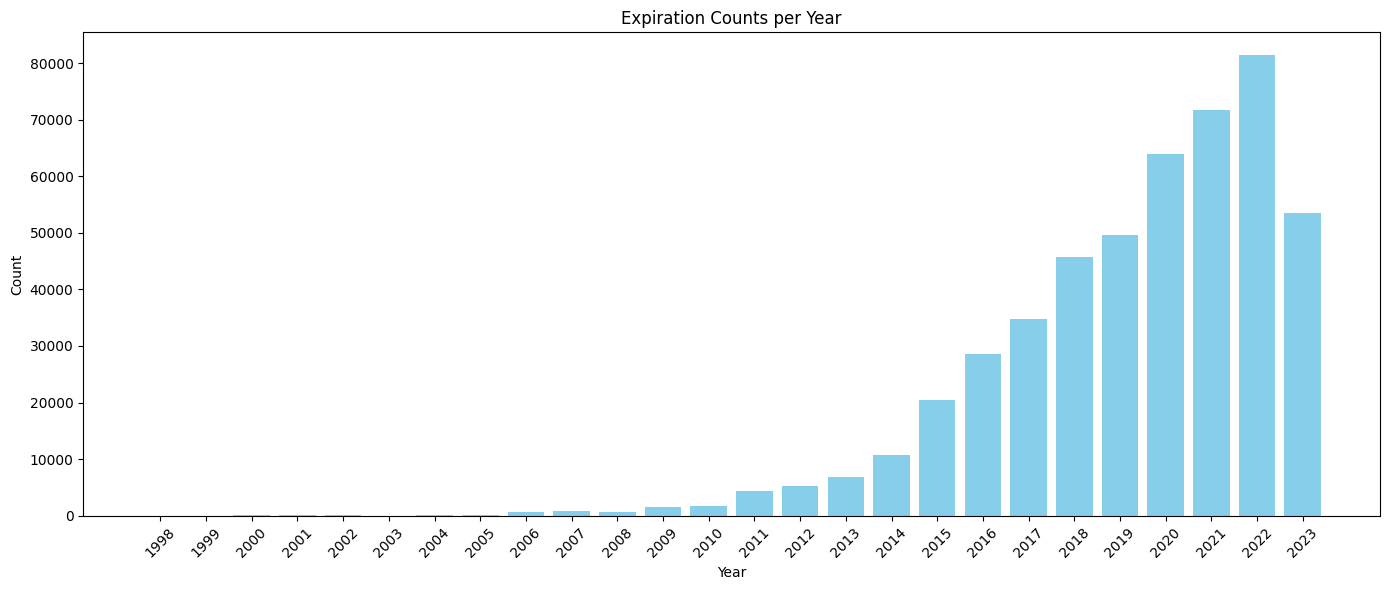

In [34]:
# Prepare the data
years = pd.to_datetime(oneDTE_df['exdate']).dt.year.tolist()
counter_dict = dict(Counter(years))

# Sort years and counts
sorted_years = sorted(counter_dict.keys())
counts = [counter_dict[year] for year in sorted_years]

# Create a full range of years from min to max (to avoid missing bars)
full_year_range = list(range(sorted_years[0], sorted_years[-1] + 1))

# Fill missing years with 0 counts
counts_full = [counter_dict.get(year, 0) for year in full_year_range]

plt.figure(figsize=(14,6))

# Bar plot with full range
plt.bar(full_year_range, counts_full, color='skyblue')

plt.title('Expiration Counts per Year')
plt.xlabel('Year')
plt.ylabel('Count')

# Show **every year** on x-axis, rotate labels for clarity
plt.xticks(full_year_range, rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# for weekly, the complete date starts since 2010 - Oct - 01
# for weekly, EOM and quarterly have the same settlement symbol since 2010 - Dec - 10, which is SPX (proved in SPXW)
# for weekly, the index change from JXD to SPX since 2010 forth week of May (2010-05-28)